## Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titleweight'] = 'bold'

np.random.seed(10121089)

## Create MLP Class

In [3]:
# Activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

# Mapping activation functions and their derivatives
activation_functions = {
    'relu': (relu, relu_derivative),
    'sigmoid': (sigmoid, sigmoid_derivative),
    'linear': (linear, linear_derivative), 
}

# Loss function
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def msle_loss(actual, predicted):
    log_differences = np.subtract(np.log(1 + actual), np.log(1 + predicted))
    squared_log_differences = np.square(log_differences)
    
    return np.mean(squared_log_differences)

# Multi-Layer Perceptron class
class MLP:
    def __init__(self, layer_sizes, activation_funcs):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(size_in, size_out) * np.sqrt(2. / size_in) for size_in, size_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]
        self.activations = [activation_functions[func][0] for func in activation_funcs]
        self.derivatives = [activation_functions[func][1] for func in activation_funcs]
        self.loss_history = []  # To store the loss after each epoch

    def forward(self, X):
        a = X
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            z = np.dot(a, w) + b
            a = activation(z)
            
        return a

    def backward(self, X, y):
        m = y.shape[0]
        
        # Forward pass
        activations = [X]
        zs = []
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            a = activation(z)
            activations.append(a)
            
        # Backward pass
        delta = (activations[-1] - y) / m
        deltas = [delta]
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.derivatives[i-1](zs[i-1])
            deltas.insert(0, delta)
            
        weight_gradients = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.weights))]
        bias_gradients = [np.sum(deltas[i], axis=0) for i in range(len(self.biases))]
        
        return weight_gradients, bias_gradients

    def update_parameters(self, grads, learning_rate):
        weight_gradients, bias_gradients = grads
        self.weights = [w - learning_rate * grad for w, grad in zip(self.weights, weight_gradients)]
        self.biases = [b - learning_rate * grad for b, grad in zip(self.biases, bias_gradients)]

    def train(self, X, y, epochs, learning_rate):
        global y_min, y_max, denormalize
        for epoch in range(0, epochs):
            grads = self.backward(X, y)
            self.update_parameters(grads, learning_rate)
            loss = mse_loss(y, self.forward(X))
            denormalized_loss = mse_loss(denormalize(y), denormalize(self.forward(X)))
            self.loss_history.append(denormalized_loss)
            if (epoch == 0) or ((epoch+1) % (epochs // 5)) == 0:
                print(f'Epoch [{(epoch+1):5.0f}/{epochs}]:\tLoss = {(loss):8.6f}\t\tDenormalized Loss = {denormalized_loss:13.6f}')

## Necessary Functions

In [4]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def denormalize(y):
    global y_min, y_max
    return y*(y_max - y_min) + y_min

def train_test_splitting(X, y, train_fraction):
    index = int(np.round(X.shape[0] * train_fraction))
    X_train, X_test = X[:index, :], X[index:, :]
    y_train, y_test = y[:index], y[index:]
    print(f'Train size: {y_train.shape[0]} rows ({train_fraction*100}%), Test size: {y_test.shape[0]} rows ({(1-train_fraction)*100}%)')
    return X_train, X_test, y_train, y_test

def plot_loss_function(loss_history):
    # Plotting the loss history
    plt.figure(figsize=(12, 5))
#     loss = denormalize(np.array(loss_history))
    plt.plot(loss_history)
    plt.title("Mean Squared Error (MSE) Loss Over Training")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
#     plt.grid()
    plt.show()
    
def plot_prediction(y_actual, y_pred, y_train_pred):
    plt.figure(figsize=(12, 5))
    plt.plot(y_actual, color="blue", label='Actual')
    plt.plot(y_pred, color='orange', label='Predicted (Test)')
    plt.plot(y_train_pred, color='red', label='Predicted (Train)')
    plt.title("Hasil Pemodelan dan Prediksi Harga Penutupan Saham BBRI")
    plt.legend()
    plt.xlabel("Day")
    plt.ylabel("Price (IDR)")
#     plt.grid()
    plt.show()

## Data Preparation

In [5]:
# Data preparation
df = pd.read_csv("bbri_1y.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           239 non-null    int64  
 1   Open           239 non-null    float64
 2   High           239 non-null    float64
 3   Low            239 non-null    float64
 4   Close          239 non-null    float64
 5   Volume         239 non-null    int64  
 6   AdjustedClose  239 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 13.2 KB
None


,Date,Open,High,Low,Close,Volume,AdjustedClose
0,20230306,4790.0,4800.0,4780.0,4790.0,78880100,4790.0
1,20230307,4770.0,4850.0,4770.0,4840.0,98412500,4840.0
2,20230308,4850.0,4850.0,4820.0,4840.0,103767800,4840.0
3,20230309,4860.0,4870.0,4810.0,4810.0,79549800,4810.0
4,20230310,4820.0,4830.0,4800.0,4820.0,125157100,4820.0


## Data Visualization

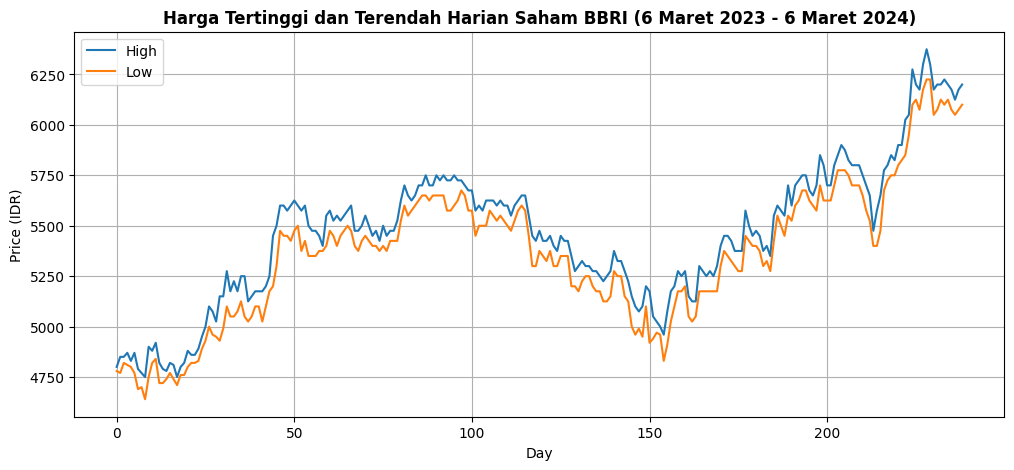

In [6]:
# Data visualization
plt.figure(figsize=(12, 5))
# df["Close"].plot()
# df["Open"].plot()
df["High"].plot()
df["Low"].plot()
plt.title("Harga Tertinggi dan Terendah Harian Saham BBRI (6 Maret 2023 - 6 Maret 2024)")
plt.xlabel("Day")
plt.ylabel("Price (IDR)")
plt.legend()
plt.show()

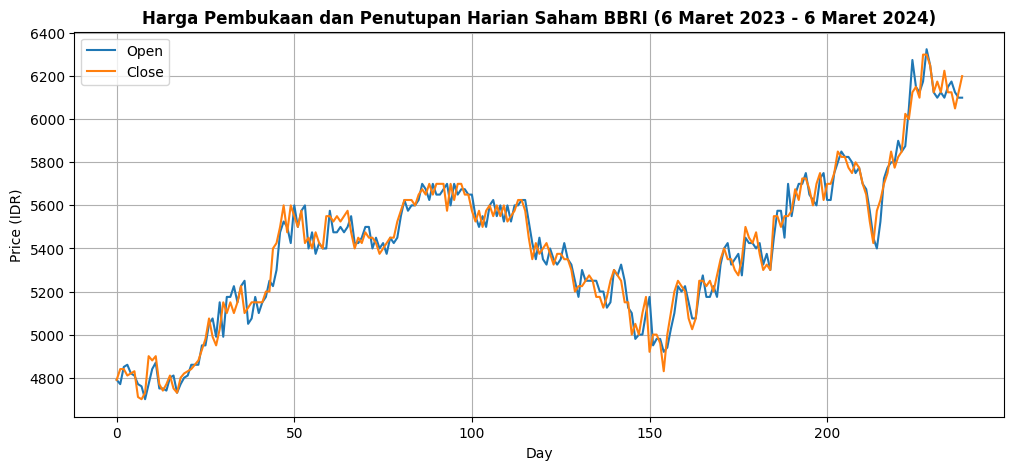

In [7]:
# Data visualization
plt.figure(figsize=(12, 5))
df["Open"].plot()
df["Close"].plot()
plt.title("Harga Pembukaan dan Penutupan Harian Saham BBRI (6 Maret 2023 - 6 Maret 2024)")
plt.xlabel("Day")
plt.ylabel("Price (IDR)")
plt.legend()
plt.show()

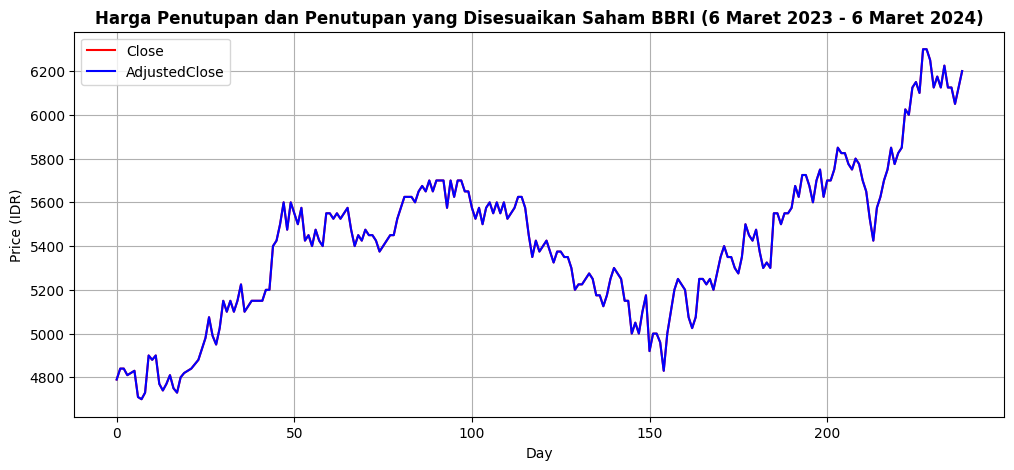

In [8]:
# Data visualization
plt.figure(figsize=(12, 5))
df["Close"].plot(color="red")
df["AdjustedClose"].plot(color="blue")
plt.title("Harga Penutupan dan Penutupan yang Disesuaikan Saham BBRI (6 Maret 2023 - 6 Maret 2024)")
plt.xlabel("Day")
plt.ylabel("Price (IDR)")
plt.legend()
plt.show()

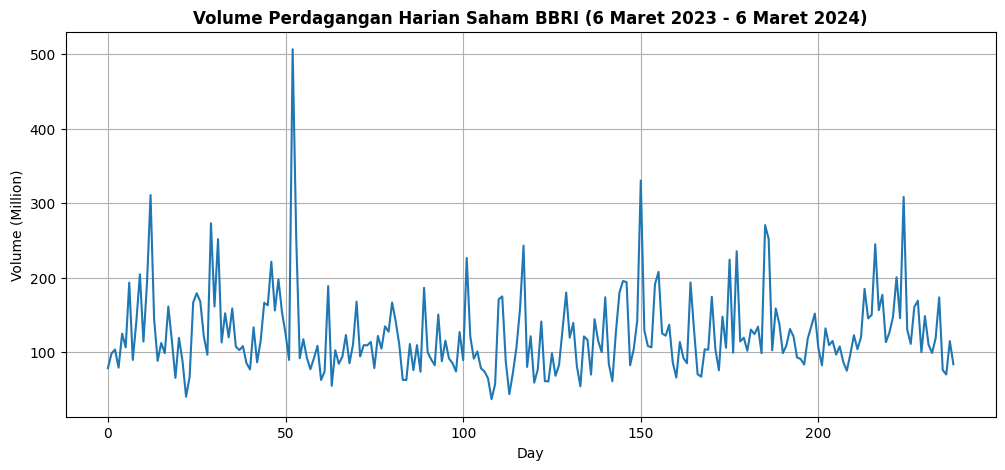

In [9]:
plt.figure(figsize=(12, 5))
a = df["Volume"] / 1000000
a.plot()
plt.title("Volume Perdagangan Harian Saham BBRI (6 Maret 2023 - 6 Maret 2024)")
plt.xlabel("Day")
plt.ylabel("Volume (Million)")
plt.show()

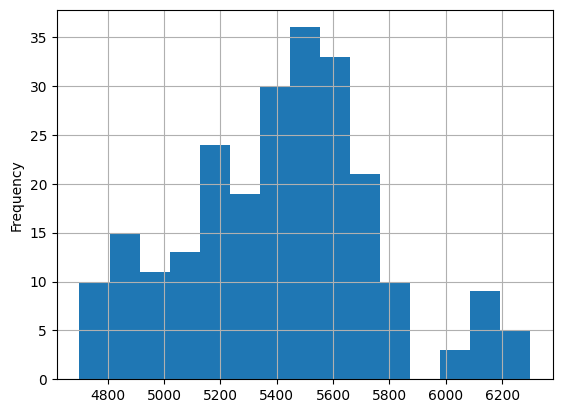

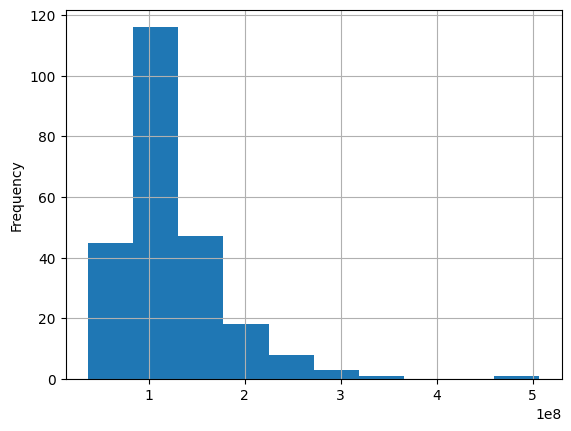

In [10]:
df["Close"].plot(kind="hist", bins=15)
plt.show()

df["Volume"].plot(kind="hist", bins=10)
plt.show()

## Data Transformation

In [11]:
# Feature scaling (normalization)
y_min = df["Close"].min()
y_max = df["Close"].max()
df_n = normalize(df)
df_n.head()

,Date,Open,High,Low,Close,Volume,AdjustedClose
0,0.0000,0.055385,0.030769,0.088328,0.05625,0.088885,0.05625
1,0.0001,0.043077,0.061538,0.082019,0.08750,0.130465,0.08750
2,0.0002,0.092308,0.061538,0.113565,0.08750,0.141866,0.08750
3,0.0003,0.098462,0.073846,0.107256,0.06875,0.090310,0.06875
4,0.0004,0.073846,0.049231,0.100946,0.07500,0.187399,0.07500


In [12]:
# Define predictor and response variables
df_x = df_n[["Open", "High", "Low", "Volume"]]
df_y = df_n["Close"]
X = np.array(df_x)
y = np.array(df_y).reshape(df_y.shape[0], 1)
print(f'Input shape: {X.shape}, Output shape: {y.shape}')

# Train test split
X_train, X_test, y_train, y_test = train_test_splitting(X, y, train_fraction=0.75)

Input shape: (239, 4), Output shape: (239, 1)
Train size: 179 rows (75.0%), Test size: 60 rows (25.0%)


## Model Training and Evaluation

### Model Utama (1 Hidden Layer)

Epoch [    1/2000]:	Loss = 0.029305		Denormalized Loss =  75020.911915
Epoch [  400/2000]:	Loss = 0.000937		Denormalized Loss =   2399.351379
Epoch [  800/2000]:	Loss = 0.000750		Denormalized Loss =   1920.251082
Epoch [ 1200/2000]:	Loss = 0.000698		Denormalized Loss =   1786.722436
Epoch [ 1600/2000]:	Loss = 0.000663		Denormalized Loss =   1698.418614
Epoch [ 2000/2000]:	Loss = 0.000640		Denormalized Loss =   1639.024136


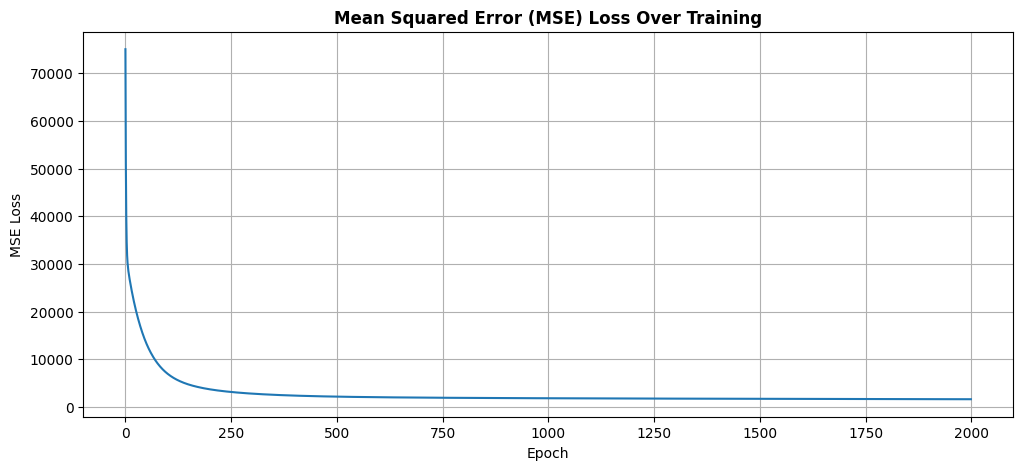

Train MSE: 1639.024136	Test MSE: 1885.833108


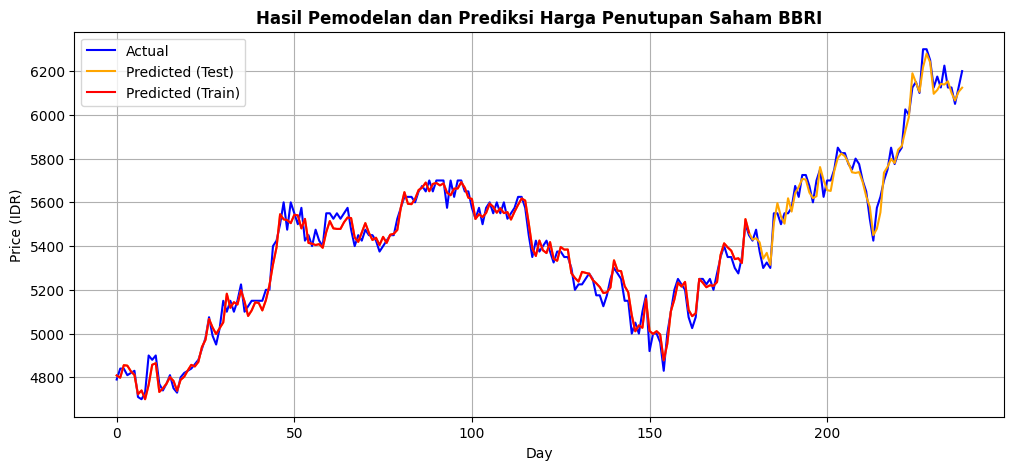

In [13]:
np.random.seed(10121089)

# Initialize and train the model
layer_sizes = [X.shape[1], 4, y.shape[1]]
activation_funcs = ['relu', 'relu']  # Specify activation functions for each layer
mlp = MLP(layer_sizes, activation_funcs)

mlp.train(X_train, y_train, epochs=2000, learning_rate=0.1)
plot_loss_function(mlp.loss_history)

y_train_actual, y_test_actual = denormalize(y_train), denormalize(y_test)
y_actual = np.append(y_train_actual, y_test_actual)

# Prediction and plotting results
y_train_pred, y_test_pred = denormalize(mlp.forward(X_train)), denormalize(mlp.forward(X_test))
y_pred = np.append(y_train_pred, y_test_pred)

mse_train, mse_test = mse_loss(y_train_actual, y_train_pred), mse_loss(y_test_actual, y_test_pred)
print(f'Train MSE: {mse_train:.6f}\tTest MSE: {mse_test:.6f}')

plot_prediction(y_actual, y_pred, y_train_pred)

### Pengaruh Jumlah Neuron pada Hidden Layer

In [14]:
num_nodes = [1, 2, 3, 4, 5, 6, 7]
mse_train_list, mse_test_list = [], []
for num in num_nodes:
    np.random.seed(10121089)
    # Initialize and train the model
    layer_sizes = [X.shape[1], num, y.shape[1]]
    activation_funcs = ['relu', 'relu']  # Specify activation functions for each layer
    mlp = MLP(layer_sizes, activation_funcs)

    mlp.train(X_train, y_train, epochs=2000, learning_rate=0.1)
#     plot_loss_function(mlp.loss_history)

    y_train_actual, y_test_actual = denormalize(y_train), denormalize(y_test)
    y_actual = np.append(y_train_actual, y_test_actual)

    # Prediction and plotting results
    y_train_pred, y_test_pred = denormalize(mlp.forward(X_train)), denormalize(mlp.forward(X_test))
    y_pred = np.append(y_train_pred, y_test_pred)

    mse_train, mse_test = mse_loss(y_train_actual, y_train_pred), mse_loss(y_test_actual, y_test_pred)
    print(f'Train MSE: {mse_train}\tTest MSE: {mse_test}')
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

#     plot_prediction(y_actual, y_pred, y_train_pred)

Epoch [    1/2000]:	Loss = 0.137816		Denormalized Loss = 352809.701390
Epoch [  400/2000]:	Loss = 0.029389		Denormalized Loss =  75236.718579
Epoch [  800/2000]:	Loss = 0.029389		Denormalized Loss =  75236.718579
Epoch [ 1200/2000]:	Loss = 0.029389		Denormalized Loss =  75236.718579
Epoch [ 1600/2000]:	Loss = 0.029389		Denormalized Loss =  75236.718579
Epoch [ 2000/2000]:	Loss = 0.029389		Denormalized Loss =  75236.718579
Train MSE: 75236.71857932025	Test MSE: 320404.9248098791
Epoch [    1/2000]:	Loss = 0.141745		Denormalized Loss = 362867.372428
Epoch [  400/2000]:	Loss = 0.029872		Denormalized Loss =  76473.265102
Epoch [  800/2000]:	Loss = 0.029240		Denormalized Loss =  74853.513969
Epoch [ 1200/2000]:	Loss = 0.029233		Denormalized Loss =  74836.765486
Epoch [ 1600/2000]:	Loss = 0.029228		Denormalized Loss =  74823.134453
Epoch [ 2000/2000]:	Loss = 0.029223		Denormalized Loss =  74811.940058
Train MSE: 74811.94005832892	Test MSE: 321519.9282322917
Epoch [    1/2000]:	Loss = 0.16358

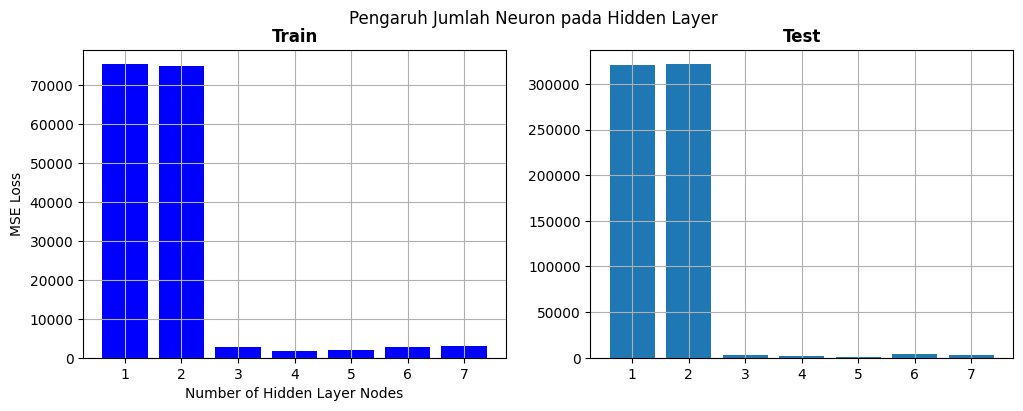

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ax[0].bar(num_nodes, mse_train_list, color="blue")
ax[0].set_xlabel("Number of Hidden Layer Nodes")
ax[0].set_title("Train")
ax[0].set_ylabel("MSE Loss")
ax[1].set_title("Test")
ax[1].bar(num_nodes, mse_test_list)
fig.suptitle("Pengaruh Jumlah Neuron pada Hidden Layer")
plt.show()

### Pengaruh Learning Rate

In [16]:
learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.7]
mse_train_list, mse_test_list = [], []
for alpha in learning_rates:
    np.random.seed(10121089)
    # Initialize and train the model
    layer_sizes = [X.shape[1], 4, y.shape[1]]
    activation_funcs = ['relu', 'relu']  # Specify activation functions for each layer
    mlp = MLP(layer_sizes, activation_funcs)

    mlp.train(X_train, y_train, epochs=2000, learning_rate=alpha)
#     plot_loss_function(mlp.loss_history)

    y_train_actual, y_test_actual = denormalize(y_train), denormalize(y_test)
    y_actual = np.append(y_train_actual, y_test_actual)

    # Prediction and plotting results
    y_train_pred, y_test_pred = denormalize(mlp.forward(X_train)), denormalize(mlp.forward(X_test))
    y_pred = np.append(y_train_pred, y_test_pred)

    mse_train, mse_test = mse_loss(y_train_actual, y_train_pred), mse_loss(y_test_actual, y_test_pred)
    print(f'MSE Train: {mse_train}\tMSE Test: {mse_test}')
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

#     plot_prediction(y_actual, y_pred, y_train_pred)

Epoch [    1/2000]:	Loss = 0.046977		Denormalized Loss = 120260.731343
Epoch [  400/2000]:	Loss = 0.006210		Denormalized Loss =  15898.131838
Epoch [  800/2000]:	Loss = 0.003457		Denormalized Loss =   8849.581118
Epoch [ 1200/2000]:	Loss = 0.002294		Denormalized Loss =   5872.293283
Epoch [ 1600/2000]:	Loss = 0.001753		Denormalized Loss =   4486.606576
Epoch [ 2000/2000]:	Loss = 0.001457		Denormalized Loss =   3730.216648
MSE Train: 3730.216647796611	MSE Test: 4919.9014000193765
Epoch [    1/2000]:	Loss = 0.044709		Denormalized Loss = 114455.425593
Epoch [  400/2000]:	Loss = 0.003455		Denormalized Loss =   8845.055826
Epoch [  800/2000]:	Loss = 0.001752		Denormalized Loss =   4485.263507
Epoch [ 1200/2000]:	Loss = 0.001273		Denormalized Loss =   3259.012455
Epoch [ 1600/2000]:	Loss = 0.001057		Denormalized Loss =   2706.632523
Epoch [ 2000/2000]:	Loss = 0.000937		Denormalized Loss =   2399.918848
MSE Train: 2399.918847931435	MSE Test: 2992.8057844265377
Epoch [    1/2000]:	Loss = 0.038

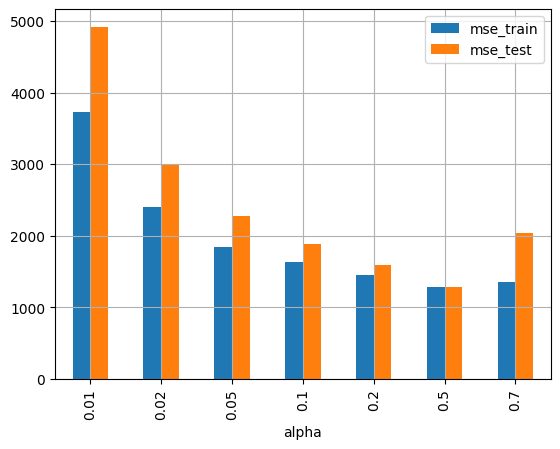

In [17]:
data = pd.DataFrame({"alpha": learning_rates, "mse_train": mse_train_list, "mse_test": mse_test_list})
data.plot(kind="bar", x="alpha", y=["mse_train", "mse_test"])
plt.show()

### Pengaruh Jumlah Epoch

In [18]:
num_epochs = [500, 1000, 2000, 3000, 5000, 10000]
mse_train_list, mse_test_list = [], []
for epochs in num_epochs:
    np.random.seed(10121089)
    # Initialize and train the model
    layer_sizes = [X.shape[1], 4, y.shape[1]]
    activation_funcs = ['relu', 'relu']  # Specify activation functions for each layer
    mlp = MLP(layer_sizes, activation_funcs)

    mlp.train(X_train, y_train, epochs=epochs, learning_rate=0.1)
#     plot_loss_function(mlp.loss_history)

    y_train_actual, y_test_actual = denormalize(y_train), denormalize(y_test)
    y_actual = np.append(y_train_actual, y_test_actual)

    # Prediction and plotting results
    y_train_pred, y_test_pred = denormalize(mlp.forward(X_train)), denormalize(mlp.forward(X_test))
    y_pred = np.append(y_train_pred, y_test_pred)

    mse_train, mse_test = mse_loss(y_train_actual, y_train_pred), mse_loss(y_test_actual, y_test_pred)
    print(f'MSE Train: {mse_train}\tMSE Test: {mse_test}')
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

#     plot_prediction(y_actual, y_pred, y_train_pred)

Epoch [    1/500]:	Loss = 0.029305		Denormalized Loss =  75020.911915
Epoch [  100/500]:	Loss = 0.002744		Denormalized Loss =   7025.835811
Epoch [  200/500]:	Loss = 0.001454		Denormalized Loss =   3723.392232
Epoch [  300/500]:	Loss = 0.001098		Denormalized Loss =   2812.070644
Epoch [  400/500]:	Loss = 0.000937		Denormalized Loss =   2399.351379
Epoch [  500/500]:	Loss = 0.000852		Denormalized Loss =   2181.703524
MSE Train: 2181.7035237284076	MSE Test: 2752.315323657308
Epoch [    1/1000]:	Loss = 0.029305		Denormalized Loss =  75020.911915
Epoch [  200/1000]:	Loss = 0.001454		Denormalized Loss =   3723.392232
Epoch [  400/1000]:	Loss = 0.000937		Denormalized Loss =   2399.351379
Epoch [  600/1000]:	Loss = 0.000804		Denormalized Loss =   2057.367135
Epoch [  800/1000]:	Loss = 0.000750		Denormalized Loss =   1920.251082
Epoch [ 1000/1000]:	Loss = 0.000719		Denormalized Loss =   1841.791420
MSE Train: 1841.7914204745352	MSE Test: 2276.8996871182876
Epoch [    1/2000]:	Loss = 0.029305		

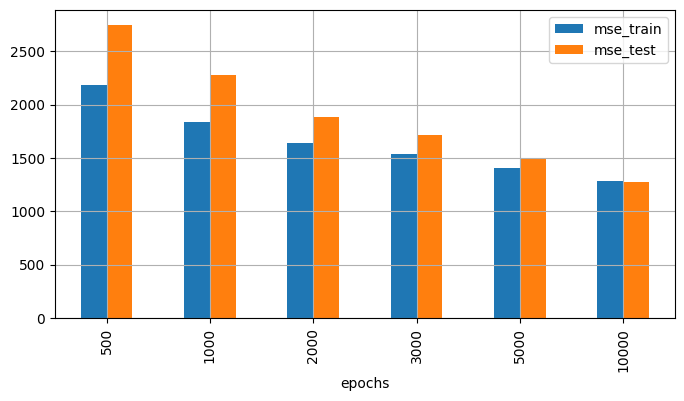

In [19]:
data = pd.DataFrame({"epochs": num_epochs, "mse_train": mse_train_list, "mse_test": mse_test_list})
data.plot(kind="bar", x="epochs", y=["mse_train", "mse_test"], figsize=(8, 4))
plt.show()

### Pengaruh Jenis Fungsi Aktivasi

In [20]:
activation_funcs_list = [["relu", "relu"], 
                         ["relu", "sigmoid"], 
                         ["sigmoid", "relu"], 
                         ["relu", "linear"], 
                         ["linear", "relu"], 
                         ["sigmoid", "linear"], 
                         ["linear", "sigmoid"]]
mse_train_list, mse_test_list = [], []
for activation_funcs in activation_funcs_list:
    np.random.seed(10121089)
    # Initialize and train the model
    layer_sizes = [X.shape[1], 4, y.shape[1]]
    #activation_funcs = ['relu', 'relu']  # Specify activation functions for each layer
    mlp = MLP(layer_sizes, activation_funcs)

    mlp.train(X_train, y_train, epochs=2000, learning_rate=0.1)
#     plot_loss_function(mlp.loss_history)

    y_train_actual, y_test_actual = denormalize(y_train), denormalize(y_test)
    y_actual = np.append(y_train_actual, y_test_actual)

    # Prediction and plotting results
    y_train_pred, y_test_pred = denormalize(mlp.forward(X_train)), denormalize(mlp.forward(X_test))
    y_pred = np.append(y_train_pred, y_test_pred)

    mse_train, mse_test = mse_loss(y_train_actual, y_train_pred), mse_loss(y_test_actual, y_test_pred)
    print(f'MSE Train: {mse_train}\tMSE Test: {mse_test}')
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

#     plot_prediction(y_actual, y_pred, y_train_pred)

Epoch [    1/2000]:	Loss = 0.029305		Denormalized Loss =  75020.911915
Epoch [  400/2000]:	Loss = 0.000937		Denormalized Loss =   2399.351379
Epoch [  800/2000]:	Loss = 0.000750		Denormalized Loss =   1920.251082
Epoch [ 1200/2000]:	Loss = 0.000698		Denormalized Loss =   1786.722436
Epoch [ 1600/2000]:	Loss = 0.000663		Denormalized Loss =   1698.418614
Epoch [ 2000/2000]:	Loss = 0.000640		Denormalized Loss =   1639.024136
MSE Train: 1639.0241356964136	MSE Test: 1885.8331083676765
Epoch [    1/2000]:	Loss = 0.054341		Denormalized Loss = 139114.232226
Epoch [  400/2000]:	Loss = 0.003340		Denormalized Loss =   8550.540111
Epoch [  800/2000]:	Loss = 0.001322		Denormalized Loss =   3385.223981
Epoch [ 1200/2000]:	Loss = 0.001290		Denormalized Loss =   3302.854803
Epoch [ 1600/2000]:	Loss = 0.001283		Denormalized Loss =   3284.139469
Epoch [ 2000/2000]:	Loss = 0.001268		Denormalized Loss =   3245.974589
MSE Train: 3245.9745890154923	MSE Test: 3919.9311814244707
Epoch [    1/2000]:	Loss = 0.0

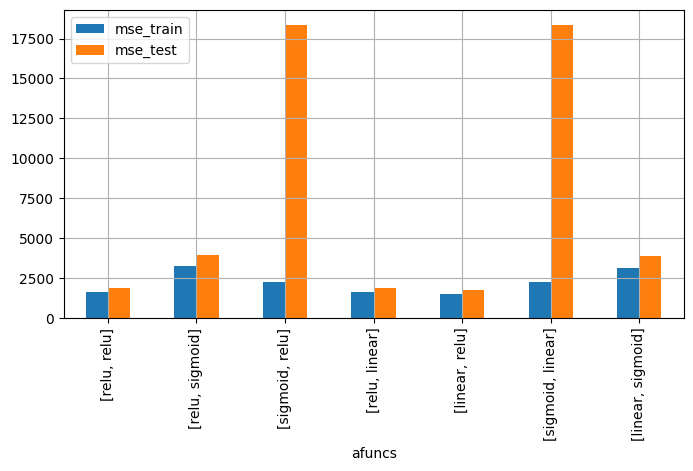

In [21]:
data = pd.DataFrame({"afuncs": activation_funcs_list, "mse_train": mse_train_list, "mse_test": mse_test_list})
data.plot(kind="bar", x="afuncs", y=["mse_train", "mse_test"], figsize=(8, 4))
plt.show()

### Pengaruh Jumlah Hidden Layer

In [22]:
num_hidden_layers = [1, 2, 3, 4]
mse_train_list, mse_test_list = [], []
for num in num_hidden_layers:
    np.random.seed(10121089)
    # Initialize and train the model
    layer_sizes = [X.shape[1], y.shape[1]]
    for i in range(num):
        layer_sizes.insert(1, 4)
    print(layer_sizes)
    activation_funcs = ['relu' for i in range(num+1)]  # Specify activation functions for each layer
    mlp = MLP(layer_sizes, activation_funcs)

    mlp.train(X_train, y_train, epochs=2000, learning_rate=0.1)
#     plot_loss_function(mlp.loss_history)

    y_train_actual, y_test_actual = denormalize(y_train), denormalize(y_test)
    y_actual = np.append(y_train_actual, y_test_actual)

    # Prediction and plotting results
    y_train_pred, y_test_pred = denormalize(mlp.forward(X_train)), denormalize(mlp.forward(X_test))
    y_pred = np.append(y_train_pred, y_test_pred)

    mse_train, mse_test = mse_loss(y_train_actual, y_train_pred), mse_loss(y_test_actual, y_test_pred)
    print(f'MSE Train: {mse_train}\tMSE Test: {mse_test}')
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

#     plot_prediction(y_actual, y_pred, y_train_pred)

[4, 4, 1]
Epoch [    1/2000]:	Loss = 0.029305		Denormalized Loss =  75020.911915
Epoch [  400/2000]:	Loss = 0.000937		Denormalized Loss =   2399.351379
Epoch [  800/2000]:	Loss = 0.000750		Denormalized Loss =   1920.251082
Epoch [ 1200/2000]:	Loss = 0.000698		Denormalized Loss =   1786.722436
Epoch [ 1600/2000]:	Loss = 0.000663		Denormalized Loss =   1698.418614
Epoch [ 2000/2000]:	Loss = 0.000640		Denormalized Loss =   1639.024136
MSE Train: 1639.0241356964136	MSE Test: 1885.8331083676765
[4, 4, 4, 1]
Epoch [    1/2000]:	Loss = 0.080474		Denormalized Loss = 206014.635978
Epoch [  400/2000]:	Loss = 0.001997		Denormalized Loss =   5112.427805
Epoch [  800/2000]:	Loss = 0.001194		Denormalized Loss =   3056.987928
Epoch [ 1200/2000]:	Loss = 0.001087		Denormalized Loss =   2783.817956
Epoch [ 1600/2000]:	Loss = 0.001049		Denormalized Loss =   2686.413548
Epoch [ 2000/2000]:	Loss = 0.001022		Denormalized Loss =   2616.552217
MSE Train: 2616.5522171296634	MSE Test: 3002.6774840639987
[4, 4, 

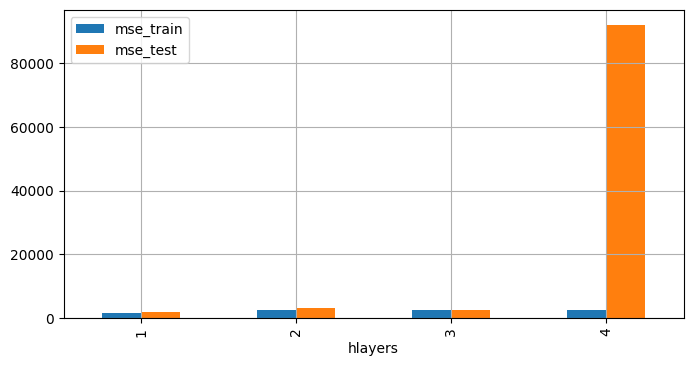

In [23]:
data = pd.DataFrame({"hlayers": num_hidden_layers, "mse_train": mse_train_list, "mse_test": mse_test_list})
data.plot(kind="bar", x="hlayers", y=["mse_train", "mse_test"], figsize=(8, 4))
plt.show()